## Feature extraction and selection
Feature extraction has the goal of reducing the dimensionality and complexity of the input data. But we do not want to remove relevant information. [source](https://domino.ai/data-science-dictionary/feature-extraction)

Feature types
Residential load characteristics are complex patterns made up of intertwined effects of multiple factors.
Weather, resident behavior, holidays
* Weather: temperature, humidity, pressure, rainfall, snowfall, lagged temperature (Andreas)
* Calendar: date, time, weekday/weekend, holiday, season/ quartile of year
* Holiday, boolean indicator, occupation (in house or not), election days, national holidays (workalender package)
* Interaction
* Historical load: lagged values, multiple lagged values (t-1, t-2, t-3), moving average
* Sub-metering: Disaggregation (Kitchen, laundry room, appliances, etc.) vs Aggregation (Total energy consumption)
* Building meta data: Indoor temperature
* Building type

Methods:
* Correlation analysis: Pearson and Spearman, PCA
* Feature importance (MLR and XGBoost)
* Autocorrelation (Simple and partial)
* Autoregressive Integrated Moving Average (ARIMA), help with time window?
* GARCH is similar to ARIMA, but instead of focusing on the average, it looks at the variance.
* Granger causality (Andreas gjorde noe med dette for moving average)
* Generalized Additive Models (GAM) for nonlinearity

In [35]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import grangercausalitytests
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [36]:
morocco = pd.read_csv("../data/raw/morocco.csv")

In [37]:
# A little processing
morocco['Consumption'] = morocco['Zone 1 Power Consumption'] + morocco['Zone 2  Power Consumption'] + morocco['Zone 3  Power Consumption']
morocco = morocco.drop(['Zone 1 Power Consumption','Zone 2  Power Consumption', 'Zone 3  Power Consumption'], axis=1)

morocco['DateTime'] = pd.to_datetime(morocco['DateTime'], format='%m/%d/%Y %H:%M')
morocco['year'] = morocco['DateTime'].dt.year
morocco['month'] = morocco['DateTime'].dt.month
morocco['day'] = morocco['DateTime'].dt.day
morocco['hour'] = morocco['DateTime'].dt.hour
morocco = morocco.drop(columns=['DateTime'])

In [38]:
morocco.dtypes

Temperature              float64
Humidity                 float64
Wind Speed               float64
general diffuse flows    float64
diffuse flows            float64
Consumption              float64
year                       int32
month                      int32
day                        int32
hour                       int32
dtype: object

In [39]:
morocco.isnull().sum()

Temperature              0
Humidity                 0
Wind Speed               0
general diffuse flows    0
diffuse flows            0
Consumption              0
year                     0
month                    0
day                      0
hour                     0
dtype: int64

#### Autoencoder
Autoencoders can help identify key features to keep. This is done by training a neural network, then reducing its dimensionality before trying to recreate the outcome. (correct?) Add an image here as well.

#### Principle Component Analysis (PCA)


#### Pearson and Spearman
The Pearson correlation coefficient measures the linear relationship between two continuous variables, while the Spearman correlation coefficient measures the monotonic relationship between two variables. Unlike Pearson, it does not assume a linear relationship and instead assesses how well the relationship between two variables can be described using a monotonic function.  

Spearman correlation is particularly useful when your data is not normally distributed or when the relationship between variables is nonlinear but monotonic, which can be the case in this application. This coefficient can help identify features that have a strong monotonic relationship with the target variable, which might not be apparent with Pearson. However, some limitations may appear in situations where the relations are complex with highly nonlinear and non-monotonic.

These methods can help us identify and possibly remove features that are highly correlated with each other (multicollinearity), which can reduce overfitting and therefore improve model performance.

In [5]:
# Calculate the correlation coefficients using Pearson method
pearson_corr = morocco.corr(method='pearson')

# Calculate the correlation coefficients using Spearman method
spearman_corr = morocco.corr(method='spearman')

In [8]:
# Correlation of all features with the target variable

pearson_target_corr = pearson_corr['Consumption'].sort_values(ascending=False).rename('Pearson')
spearman_target_corr = spearman_corr['Consumption'].sort_values(ascending=False).rename('Spearman')

correlation_with_target = pd.DataFrame(data={'Pearson': pearson_target_corr, 'Spearman': spearman_target_corr})

print("Correlation of all features with 'Consumption':")
display(correlation_with_target)

Correlation of all features with 'Consumption':


,Pearson,Spearman
Consumption,1.000000,1.000000
Humidity,-0.299059,-0.305526
Temperature,0.488238,0.468684
Wind Speed,0.221706,0.106769
day,0.025144,0.023660
diffuse flows,0.032068,0.082184
general diffuse flows,0.150368,0.226824
hour,0.679532,0.693876
month,0.004587,-0.006469
year,NaN,NaN


In [21]:
print('Pearson')
print(pearson_target_corr)
print('Spearman')
print(spearman_target_corr)

Pearson
Consumption              1.000000
hour                     0.679532
Temperature              0.488238
Wind Speed               0.221706
general diffuse flows    0.150368
diffuse flows            0.032068
day                      0.025144
month                    0.004587
Humidity                -0.299059
year                          NaN
Name: Pearson, dtype: float64
Spearman
Consumption              1.000000
hour                     0.693876
Temperature              0.468684
general diffuse flows    0.226824
Wind Speed               0.106769
diffuse flows            0.082184
day                      0.023660
month                   -0.006469
Humidity                -0.305526
year                          NaN
Name: Spearman, dtype: float64


In [15]:
morocco['year'].value_counts()

year
2017    52416
Name: count, dtype: int64

The correlation for `year` is probably `NaN` because we don't have any variability in the feature.

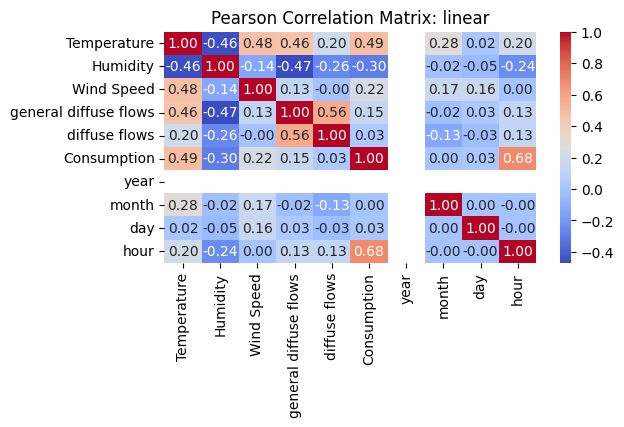

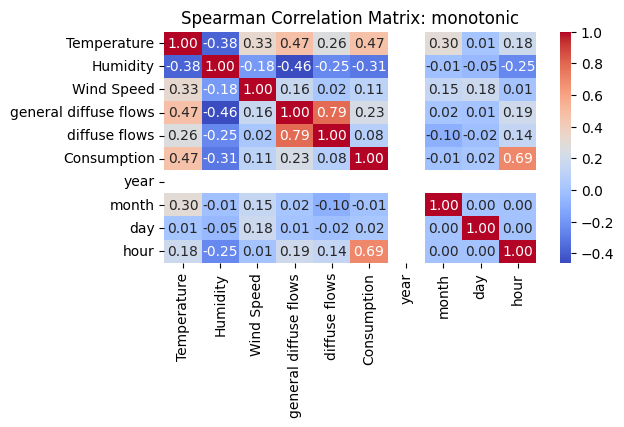

In [19]:
# Visualization: scatter plots, pair plots, and heatmaps

# Display Pearson Correlation Matrix
plt.figure(figsize=(6,3))
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Pearson Correlation Matrix: linear')
plt.show()

# Display Spearman Correlation Matrix
plt.figure(figsize=(6,3))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Spearman Correlation Matrix: monotonic')
plt.show()

##### Conlusion for the Person and Spearman correlation coefficients
Discuss the results. If two features are highly correlated with each other (±0.70), consider removing one to reduce multicollinearity. This is less of an issue for models like LSTMs and Transformers, but simplifying your feature set can still help with model interpretability and possibly reduce overfitting.

The `hour` feature has a high correlation coefficient with `consumption` on both person and spearman, respectively. This suggests that the time of the day is significantly correlated with energy consumption. This makes sense in the context of residential buildings.

`Temperature` indicates a moderate positive linear relation with `consumption`. Higher temperature may lead to increased energy consumption, possibly due to the use of cooling systems.

`Wind speed` has a weak positive linear relation with `consumption`.

`Humidity` shows a moderate negative linear relation with `consumption`, which suggest that higher humidity levels might be associated with lower energy consumption.

Other features below absolute 0.20 correlation indicates a influence on energy consumption.

Features with higher absolute values of correlation (either Pearson for linear or Spearman for monotonic relationships) with the target variable might be more informative. Prioritize these for your model, but remember that correlation does not imply causation.

Bigger changes between the values in the Person and Spearman methods suggest that there might be nonlinear relations worth further investigation.

Further steps:  
* Transform Features: For features with a weak linear correlation (Pearson) but stronger monotonic relationship (Spearman), consider nonlinear transformations (e.g., logarithmic, square root) to potentially improve their linear relationship with the target variable.
* Temporal Features: If you're dealing with time series data, consider engineering features that capture temporal dynamics (e.g., lag features, rolling averages, time of day, day of the week) which may not directly correlate but are crucial for forecasting tasks.
 
Consider nonlinearity, check for multicollinearity
Perform some feature selection based on the coefficients

#### Granger Causality
Granger causality helps to determine if one time series can predict another time series. It does not imply a true causality, but indicates a predictive relationship between features where values from one variable can help forecast future values of another variable.  

Granger Causality considers the direction and lag of the relationships which expose how changes in predictor variables at specific time points influence the target variable at a later point.  

Granger Causality requires the time series to be stationary, which means that we might need to transform our data before testing.

Limitations:
* Many features = computationally intensive. Important to have a balance between depth of analysis and computational feasibility as we take the granger causality test between each feature and target variable.
* Not true causality, only predictive relationship based on temporal precedence. Other factors not included may also have influence.
* Like other feature extraction methods, this might not capture the complex temporal patterns in the data which neural network models and Transformers may capture. The result from the analysis should therefore be considered as a guide for feature extraction and be compared with domain knowledge and other insights.

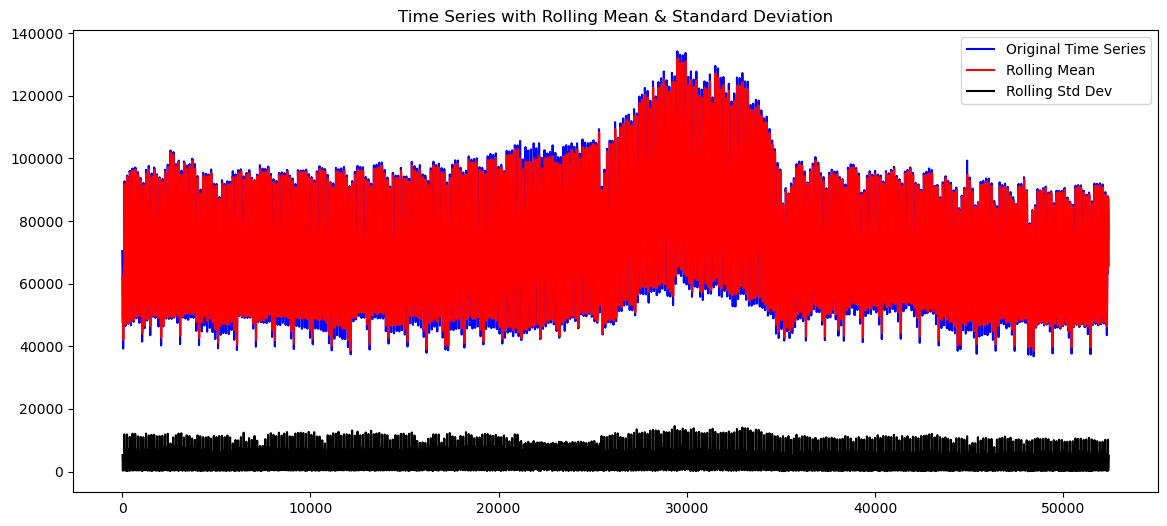

In [24]:
"""
Check if time series is stationary:
  Granger Causality assumes stationary data which requires properties
  such as mean, variance and autocorrelation to be constant over time.

  You can see if the data is stationary through visual inspection, looking for obvious changes in the patterns.
  There are also statistical approaches to test for stationary data: 
  * Augmented Dickey-Fuller (ADF) Test is one of the most common.
  * Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is another popular test.
"""

# Check for obvious changes over time: mean, trends, seasonality:
# Calculate and plot the rolling mean and rolling variance over a certain window:
rolling_mean = morocco['Consumption'].rolling(window=12).mean() # Window size can be adjusted
rolling_std = morocco['Consumption'].rolling(window=12).std()

plt.figure(figsize=(14, 6))
plt.plot(morocco['Consumption'], color='blue', label='Original Time Series')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std Dev')
plt.legend(loc='best')
plt.title('Time Series with Rolling Mean & Standard Deviation')
plt.show()

Observations:  
* Trend: The rolling mean (red line) appears to have a varying trend over time. It's not constant, and there are visible patterns and shifts. This suggests that the time series has a trend component, indicating non-stationarity.
* Seasonality: There are regular oscillations in both the original time series and the rolling mean. This periodic behavior suggests that there is a seasonal component in the data, which is another sign of non-stationarity.
* Rolling Standard Deviation: The rolling standard deviation (black line) also shows variation over time, although it seems less pronounced than the variation in the mean. However, any significant variation in the standard deviation is a sign that the time series is not stationary.
* Variance: The spread of the time series (blue) seems to increase and decrease at different time intervals, indicating changing variance, which violates the stationarity assumption.

Based on these observations, it is likely that the data is non-stationary, which is common in real world data where trends and seasonality is to be expected.

Models such as Random Forests, Gradient Boosting Machines, and Neural Networks like LSTMs (Long Short-Term Memory) or Transformers do not require the data to be stationary. However, they may benefit from stationarity in the inputs as it can make the learning process easier and the model more reliable. Stationary data can stabilize the training process and help these models learn and generalize better from the data, leading to improved performance, especially in the context of forecasting.

In [12]:
"""
Augmented Dickey-Fuller (ADF) test:
  The null hypothesis of the ADF test is that the time series
  is non-stationary due to the presence of a unit root.
"""
from statsmodels.tsa.stattools import adfuller

result = adfuller(morocco['hour'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -43.954056
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


If the p-value is low (typically ≤ 0.05), you can reject the null hypothesis and conclude the series is stationary. Also, compare the ADF statistic with the critical values; if the ADF statistic is less than the critical value, the series is stationary.

* The value of -43.954056 is far below the critical values at the 1%, 5%, and 10% levels. This indicates that the test statistic is significant.
* p-value: A p-value of 0.000000 suggests that you can reject the null hypothesis with a high degree of confidence. The null hypothesis of the ADF test is that the time series is non-stationary. Therefore, a p-value close to 0 indicates that the series does not have a unit root and is stationary.
* Critical Values: The critical value thresholds for the ADF test are provided for different confidence levels. Since the ADF statistic is lower than the critical value at the 1% level, this strongly rejects the null hypothesis of non-stationarity.

Despite the visual appearance of seasonality and changing volatility, the ADF test results suggest that the time series is stationary. Depending on the modeling technique you plan to use, you might still need to model or remove the seasonality to make the time series more predictable and amenable to analysis with certain time series forecasting methods.

In [18]:
"""
Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test:
"""
from statsmodels.tsa.stattools import kpss

result = kpss(morocco['hour'], regression='c')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))

KPSS Statistic: 0.026566
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/var/folders/jr/90trlx1148g4hs4p4rs_y01m0000gn/T/ipykernel_7864/254927081.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(morocco['hour'], regression='c')


A low p-value (typically ≤ 0.05) suggests the time series is not stationary. Unlike the ADF test, here a significant result indicates non-stationarity.

* KPSS Statistic (0.026566): This is the test statistic for the KPSS test. A lower value suggests less evidence against the null hypothesis.
* p-value (0.100000): The p-value indicates the probability of observing the test results under the null hypothesis. A high p-value (greater than 0.05) suggests that you fail to reject the null hypothesis.
* Critical Values: These are the threshold values for the test statistic at various levels of significance. If the KPSS statistic is below these values, the null hypothesis cannot be rejected.

The null hypothesis for the KPSS test is that the time series is stationary around a deterministic trend.
Since the KPSS statistic is below the 10% critical value and the p-value is high (0.10), you fail to reject the null hypothesis of stationarity at conventional significance levels (1%, 2.5%, 5%, and 10%).
This suggests that the time series does not have a trend and is stationary around a mean.

##### Interpretting ADF vs. KPSS
Unlike the Augmented Dickey-Fuller (ADF) test, which tests for a unit root (a type of non-stationarity), the KPSS test checks for the presence of a trend (deterministic stationarity).

* If both tests agree (ADF indicates stationarity and KPSS indicates non-stationarity or vice versa), you have a clear answer.
* If the results conflict, it may suggest a difference in the type of non-stationarity (trend vs. difference-stationary). In such cases, further investigation and possibly differencing or detrending the series might be necessary.

The ADF test indicated the series is stationary (no unit root).  
The KPSS test suggests the series does not have a trend and is stationary around a mean.

The KPSS test assumes that any detected trend is deterministic rather than stochastic. In practice, a time series may appear stationary around a mean in the presence of a deterministic trend that the KPSS test does not detect as stochastic.

##### Transforming the non-stationary data
If the time series is found to be non-stationary, you can apply transformations such as differencing, logarithmic, or detrending to make it stationary. The choice of transformation can depend on the specific characteristics of the time series, such as the presence of a trend or seasonality.

In [19]:
"""
Differencing:
  subtract the observation in the current period from the previous period.
  If the series has a seasonal pattern, you may need to difference by a season's length, 
  which is known as seasonal differencing
"""

# First Differencing:
diffed_series = original_series - original_series.shift(1)

#Seasonal Differencing:
seasonally_diffed_series = original_series - original_series.shift(seasonal_period)

In [ ]:
"""
Log Transformation:
  Taking the logarithm of your time series can help stabilize the variance of a series
  that exhibits exponential growth. This is a simple transformation method 
  that can work well when you have a nonlinear trend with constant elasticity.
"""
log_series = np.log(original_series)

In [ ]:
"""
Power Transformations:
  Square root, cube root, or Box-Cox transformations can help stabilize 
  variance and make the series look more like a stationary series.
"""
#Square Root: 
sqrt_series = np.sqrt(original_series)

#Cube Root: 
cbrt_series = np.cbrt(original_series)

#Box-Cox Transformation: Normal distribution
from scipy.stats import boxcox
boxcox_series, lam = boxcox(original_series)

In [ ]:
"""
Detrending:
  Detrending removes the underlying trend in the data. 
  This can be done by subtracting a trend line or model from the original series.
"""
# Polynomial or Linear Detrending: 
# Fit a linear or polynomial model and subtract the trend component from the series.

In [ ]:
"""
Decomposition:
  Separates the time series into trend, seasonal, and residual components.
  Analyze the residual component, which is what you'd expect to be stationary.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(original_series, model='additive')
residual = decomposition.resid

In [ ]:
"""
Remove seasonality:
  differencing with a lag that corresponds to the seasonal period.
"""
diff_series = morocco['hour'].diff().dropna()

# Log Transformation
log_series = np.log(morocco['hour']).dropna()

##### Granger Causality test

In [8]:
"""
Select max lags:
Domain knowledge and autocorrelation analysis might help determine an appropriate amount of lags.
* Too few lags might miss the causal relationship;
* Too many lags might make the test result fuzzy.
""" 
max_lags = 4

In [9]:
# Identify predictive relationships


gc_test_hour = grangercausalitytests(morocco[['Consumption', 'hour']], max_lags, verbose=True)

# Repeat this for other features:


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=166.5815, p=0.0000  , df_denom=52412, df_num=1
ssr based chi2 test:   chi2=166.5911, p=0.0000  , df=1
likelihood ratio test: chi2=166.3269, p=0.0000  , df=1
parameter F test:         F=166.5815, p=0.0000  , df_denom=52412, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=105.3816, p=0.0000  , df_denom=52409, df_num=2
ssr based chi2 test:   chi2=210.7833, p=0.0000  , df=2
likelihood ratio test: chi2=210.3606, p=0.0000  , df=2
parameter F test:         F=105.3816, p=0.0000  , df_denom=52409, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=70.0998 , p=0.0000  , df_denom=52406, df_num=3
ssr based chi2 test:   chi2=210.3274, p=0.0000  , df=3
likelihood ratio test: chi2=209.9065, p=0.0000  , df=3
parameter F test:         F=70.0998 , p=0.0000  , df_denom=52406, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=52.8895 

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [ ]:
# Lag on x, F-value on y

In [ ]:
# Temporal dynamics: 

In [22]:
# Focus on the features that Granger-cause the target feature

In [ ]:
# Granger Causality can give insights into optimal lag values to use for certain features.

##### Discussion on Granger Causality
For each lag, we get the F-test and p-value among other statistics. Lower p-values (typically <0.05) indicates that you can reject the null hypothesis, suggesting that the feature granger-causes the target variable at that lag. If a variable Granger-causes another, it means past values of the first variable contain information that help predict future values of the second variable.

##### Generalized Autoregressive Conditional Heteroskedasticity (GARCH)
What is the goal of GARCH, and when do we use it? What requirements does the GARCH model have on the underlying data?

Write a little bit about what kind of input it expects. Primary goal volatility (time-varying variance). Energy consumption, therefore that is the main feature. Typically we use the residuals from a mean model like ARIMA to capture volatility dynamics.

The GARCH(1,1) model is a commonly used specification where both the autoregressive and moving average components are of order 1. The conditional volatility is a measure of time-varying volatility, which can be a valuable feature for forecasting future values of energy consumption, especially if you expect volatility clustering in your data.

In [33]:
# Fit ARIMA model to model the energy consumption data
# Optionally incorporate Temperature data as exogenous variable if we find significant relationship between these.

# Adjust p, d, q values based on your data analysis (e.g., ACF, PACF plots, stationarity tests, autocorrelation plots)
p, d, q = 1, 0, 1
model = SARIMAX(morocco['Consumption'], exog=morocco['Temperature'], order=(p, d, q))
results = model.fit(disp=False)

# Use the residuals as the input for the GARCH model.
# These residuals represent the unexplained part which might be influenced by volatility clustering.
print(results.summary())
residuals = results.resid

                               SARIMAX Results                                
Dep. Variable:            Consumption   No. Observations:                52416
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -433431.333
Date:                Wed, 06 Mar 2024   AIC                         866870.666
Time:                        15:46:17   BIC                         866906.134
Sample:                             0   HQIC                        866881.752
                              - 52416                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Temperature   238.3820     18.331     13.004      0.000     202.454     274.310
ar.L1           1.0000    5.1e-05   1.96e+04      0.000       1.000       1.000
ma.L1           0.6728      0.002    400.698    

In [34]:
# fitted to the residuals of the mean model to capture the volatility in energy consumption
garch_model = arch_model(residuals, p=1, q=1, mean='zero', vol='Garch', dist='normal')
garch_result = garch_model.fit(update_freq=5)
print(garch_result.summary())

# mean='zero indicates that we're modeling the variance of the residuals without a mean component
# as the mean has already been accoutned for in the first step.

Iteration:      5,   Func. Count:     24,   Neg. LLF: 423245.0233515512
Optimization terminated successfully    (Exit mode 0)
            Current function value: 423243.13268378197
            Iterations: 9
            Function evaluations: 39
            Gradient evaluations: 9
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -423243.
Distribution:                  Normal   AIC:                           846492.
Method:            Maximum Likelihood   BIC:                           846519.
                                        No. Observations:                52416
Date:                Wed, Mar 06 2024   Df Residuals:                    52416
Time:                        15:46:43   Df Model:                            0
         

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.814e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Axes: >

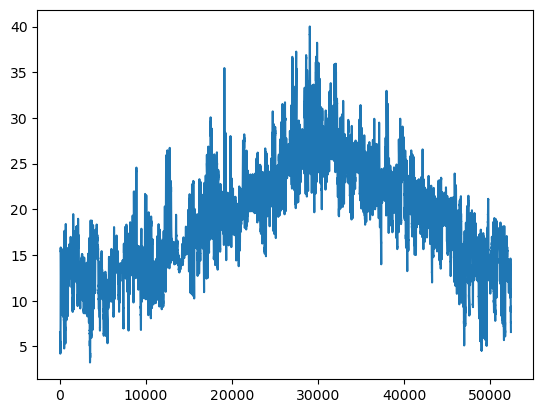

In [18]:
morocco['Temperature'].plot()

In [28]:
# Fitting a GARCH(1,1) model
# First, we'll model the residuals with a mean model (e.g., Constant Mean model)
# and then apply the GARCH(1,1) model to the residuals' variance.

time_series = morocco['Consumption']

# Here we are assuming that the residuals of your time series follow a normal distribution.
# You might want to test different distributions based on your data (e.g., 't', 'skewt')
garch_model = arch_model(time_series, vol='Garch', p=1, q=1, mean='constant', dist='normal')
model_result = garch_model.fit(update_freq=5)

print(model_result.summary())

# Extracting the conditional volatility
#morocco['conditional_volatility'] = model_result.conditional_volatility

Iteration:      5,   Func. Count:     27,   Neg. LLF: 557763.1738792369
Iteration:     10,   Func. Count:     52,   Neg. LLF: 557624.1036880374
Iteration:     15,   Func. Count:     77,   Neg. LLF: 557274.3695964024
Optimization terminated successfully    (Exit mode 0)
            Current function value: 557274.3695924178
            Iterations: 17
            Function evaluations: 87
            Gradient evaluations: 17
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Consumption   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -557274.
Distribution:                  Normal   AIC:                       1.11456e+06
Method:            Maximum Likelihood   BIC:                       1.11459e+06
                                        No. Observations:                52416
Date:                W

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [29]:
# Heat map of log likelihood
# p on x axis, q on y axis
# z is log likelihood

log_likelihoods = np.full((11, 11), np.nan)  # Use np.nan for uninitialized values
aic_values = np.full((11, 11), np.nan)

# Iterate over combinations of p and q values
for p in range(1, 11):
    for q in range(1, 11):
        try:
            # with warnings.catch_warnings():
            # warnings.filterwarnings("ignore", message="The optimizer returned code 8")
            # Fit GARCH model
            model = arch_model(time_series, p=p, q=q, mean='constant', vol='Garch', dist='normal')
            res = model.fit(disp='off', update_freq=5)
            # Store log likelihood and AIC
            log_likelihoods[p, q] = res.loglikelihood
            aic_values[p, q] = res.aic
        except:
            print(f"Model with p={p}, q={q} failed to converge")
            log_likelihoods[p, q] = np.nan
            aic_values[p, q] = np.nan

# Identifying the p, q with the minimum AIC
min_aic_index = np.unravel_index(np.nanargmin(aic_values), aic_values.shape)
print(f"Optimal p, q with minimum AIC: {min_aic_index}, AIC: {aic_values[min_aic_index]}")

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameter

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.939e+08. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/mar

Optimal p, q with minimum AIC: (1, 1), AIC: 1114556.7391848357


/Users/mariuslerstein/miniconda3/envs/master/lib/python3.12/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


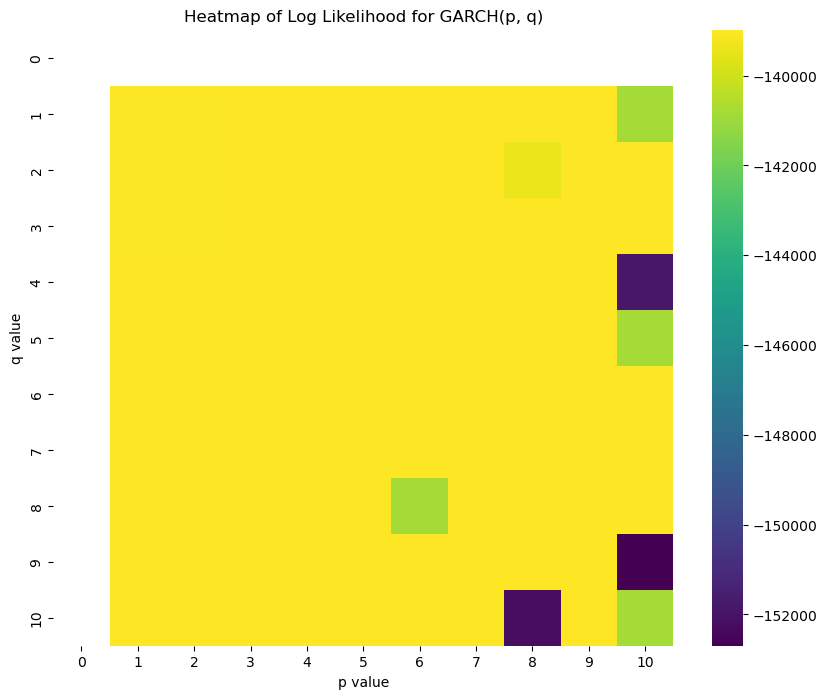

In [22]:
# Plotting the heatmap of log likelihood
plt.figure(figsize=(10, 8))
sns.heatmap(log_likelihoods, annot=True, fmt=".2f", cmap="viridis", xticklabels=range(11), yticklabels=range(11))
plt.title('Heatmap of Log Likelihood for GARCH(p, q)')
plt.xlabel('p value')
plt.ylabel('q value')
plt.show()

In [23]:
garch_model = arch_model(time_series, vol='Garch', p=2, q=10, mean='constant', dist='normal')
model_result = garch_model.fit(update_freq=5)
print(model_result.summary())

Iteration:      5,   Func. Count:     82,   Neg. LLF: 167475.71879402286
Iteration:     10,   Func. Count:    164,   Neg. LLF: 140051.12342688374
Iteration:     15,   Func. Count:    243,   Neg. LLF: 140713.10501608698
Iteration:     20,   Func. Count:    322,   Neg. LLF: 139402.40349209064
Iteration:     25,   Func. Count:    401,   Neg. LLF: 138979.367320226
Iteration:     30,   Func. Count:    482,   Neg. LLF: 141630.65312551914
Iteration:     35,   Func. Count:    576,   Neg. LLF: 138977.80387348623
Optimization terminated successfully    (Exit mode 0)
            Current function value: 138977.80387282907
            Iterations: 38
            Function evaluations: 596
            Gradient evaluations: 36
                     Constant Mean - GARCH Model Results                      
Dep. Variable:            Temperature   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log

In [27]:
# The params to use as features:
model_result.params

mu          1.996512e+01
omega       1.930860e-02
alpha[1]    9.716662e-01
alpha[2]    1.324854e-02
beta[1]     1.030496e-07
beta[2]     0.000000e+00
beta[3]     1.308882e-03
beta[4]     9.055029e-03
beta[5]     6.618334e-08
beta[6]     0.000000e+00
beta[7]     0.000000e+00
beta[8]     0.000000e+00
beta[9]     0.000000e+00
beta[10]    4.721863e-03
Name: params, dtype: float64

##### Discussion on GARCH
GARCH models can be sensitive to the choice of distribution for the residuals and the specification of the mean and variance equations. Depending on your specific dataset and hypothesis about the underlying process, you might need to adjust these settings for optimal performance.

In order to optimize the lagged values we use a brute force method where we try all combinations from 1 to 10 for both p and q. We want to minimize the AIC values, in which the brute force gave us the minimum AIC combination of p=2, q=10. A higher log likelihood suggests a better fit. 

Based on the plot it looks like the best p,q values are (8,10), (10,9) or (10,4). This discrepancy between the model with the minimum AIC and the one with the highest log likelihood can be a result of the AIC not only consider the goodness of fit via the log likelihood, but also penalizes the more complex models, that is the ones with the higher number of parameters, to discourage overfitting. A model with a higher log likelihood which also has more parameters might have a higher/ worse AIC than a simpler model with a slightly lower log likelihood, which is likely what we observe in this case.

The optimal model depends on the criteria in which we prioritizes. If our goal is purely to maximize the fit without regard to model complexity, the highest log likelihood model might be preferred. However, for general predictive performance and to avoid overfitting, the model with the lowest AIC is often chosen. This is because the AIC aims to find a model that explains the data well with as few parameters as possible, improving generalizability.

These results should bevalidated on out-of-sample tests to see if the advantages of AIC and log likelihood translate into practical forecasting performance.

Enhancements
* Initial Parameter Guesses - Improve convergence by starting from a better position. Requires good understanding.
* Model simplify - Reduce the complexity (number of parameters) to avoid convergence issues (like I encountered)
* Increate tolerence and iteration limits - make it less strict by giving the algo more room to find solution. options={'maxiter': X, 'ftol': Y} in the fit function.
* Ensure the data is stationary as non-stationary data can lead to convergence issues.

In order to improve the predictive models, we can use the results from the GARCH analysis to create an additional volatility feature, which might capture aspects of the underlying data that are related to temporal variability not directly observable through the original features.

In [ ]:
conditional_volatility = model_result.conditional_volatility
#morocco['conditional_volatility'] = conditional_volatility.values

In [ ]:
# Store the processed data
morocco.to_csv('../data/processed/morocco_processed.csv')